### Analyze some properties of ArtEmis.
    - Concreteness, 
    - Subjectivity based on TextBlob 
    - Sentimenet-Analysis based on nltk Vader
    - The above metrics on ArtEmis per art style and gerne 


In [13]:
import json
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
from collections import Counter
from functools import partial
from ast import literal_eval
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import entropy

from utils.basic import df_parallel_column_apply

sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
try:
    from textblob import TextBlob    
except:
    print('For analyzing the subjectivity need to install textblob')  
    print('e.g., conda install -c conda-forge textblob')

In [15]:
freq_file = '../../data/symspell_frequency_dictionary_en_82_765.txt'
glove_file = '../../data/glove.6B.100d.vocabulary.txt'

## Use your path:
artemis_preprocessed_csv = '/Users/Cherry0904/Desktop/official_data/artemis_preprocessed.csv'

In [16]:
load_ela = True
spell_check_non_artemis_data = False

In [17]:
### Load -datasets-
datasets = dict()
if load_ela:
    df = pd.read_csv(artemis_preprocessed_csv)
    df.tokens = df.tokens.apply(literal_eval)
    datasets['ArtEmis'] = df

In [18]:
for k, v in datasets.items():
    print(k, 'N-sentences:', len(v), 'Average Length:', v.tokens_len.mean())

ArtEmis N-sentences: 454684 Average Length: 15.920549216598781


In [29]:
##
## Sentiment Analysis
##

In [19]:
def vader_classify(score, threshold=0.05):
    if abs(score) < threshold:
        return 'neutral'

    if score > 0:
        return 'positive'

    if score < 0:
        return 'negative'
    
def vader_score(sentence):
    return vader.polarity_scores(sentence)['compound']

In [20]:
nltk.download('vader_lexicon')
sentiment_scores = dict()
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Cherry0904/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
for dset_name in datasets:    
    sentiment_scores[dset_name] = datasets[dset_name]['utterance_spelled'].apply(lambda x: vader.polarity_scores(x)['compound'])
    scores = sentiment_scores[dset_name]
    smean = scores.abs().mean()
    smedian = scores.abs().median() 
    print(dset_name, 'sentiment-score', smean, smedian)

ArtEmis sentiment-score 0.44061406383380786 0.4588


In [23]:
sentiment_classes_list = []  # aggregate for all datasets to make a nice plot
dataset_names = []
sentiment_classes = dict()
threshold = 0.05
for name in sentiment_scores:
    temp = sentiment_scores[name].apply(lambda x: vader_classify(x, threshold=threshold))
    sentiment_classes[name] = temp    
    sentiment_classes_list.extend(temp.to_list())
    dataset_names.extend(len(temp) * [name])    

In [30]:
for name in sentiment_classes:
    print(name, (sentiment_classes[name] == 'neutral').mean())

ArtEmis 0.164558242647641


In [31]:
d1 = pd.DataFrame(dataset_names, columns=['dataset'])
d2 = pd.DataFrame(sentiment_classes_list, columns=['sentiment-class'])
aggregate_sentiment_stats = pd.concat([d1, d2], axis=1)

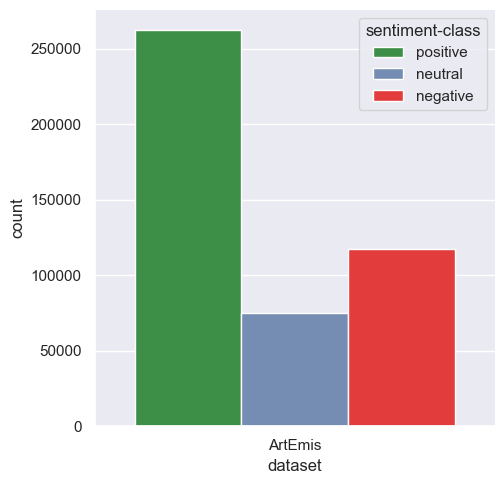

In [35]:
c = sns.catplot(x="dataset", 
                hue="sentiment-class", 
                data=aggregate_sentiment_stats, 
                kind="count",                 
                palette={"negative": "#FE2020", 
                         "positive": "#2f9c3b", 
                         "neutral": "#6b8abd"},                                
                legend_out=False,
               )
plt.show()

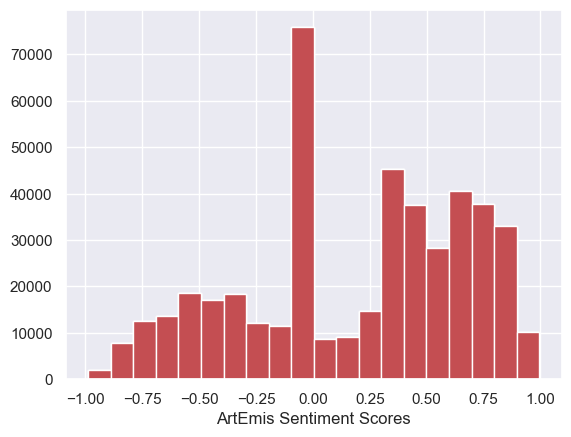

In [43]:
plt.hist(sentiment_scores['ArtEmis'], bins=20)
plt.xlabel('ArtEmis Sentiment Scores')
plt.show()

In [ ]:
##
## Subjectivity Analysis
##

In [22]:
def subjectivity(utterance):
    testimonial = TextBlob(utterance)
    return testimonial.sentiment.subjectivity

In [9]:
print(TextBlob('The painting is red').sentiment.subjectivity)
print(TextBlob('The painting is nice').sentiment.subjectivity)

0.0
1.0


In [10]:
subjectivity_scores = dict()
for dset_name in datasets:    
    subjectivity_scores[dset_name] = df_parallel_column_apply(datasets[dset_name], subjectivity, 'utterance_spelled')

In [11]:
print(subjectivity_scores['ArtEmis'].mean())
print(subjectivity_scores['ArtEmis'].median())

0.469954138382302
0.5


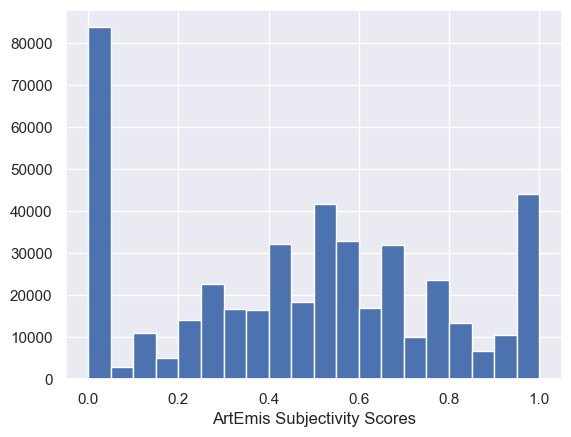

In [12]:
plt.hist(subjectivity_scores['ArtEmis'], bins=20)
plt.xlabel('ArtEmis Subjectivity Scores')
plt.show()

In [18]:
##
## Analyze subjectivity and absoliute sentiment per art style and per art genre
##

In [24]:
name = 'ArtEmis'
datasets[name]['subjectivity_scores'] = subjectivity_scores[name]
datasets[name]['sentiment_abs_scores'] = sentiment_scores[name].abs()

In [25]:
g = pd.read_csv('../../data/wiki_art_genre_class.csv')
m = pd.merge(datasets['ArtEmis'], g, on=['art_style', 'painting'])

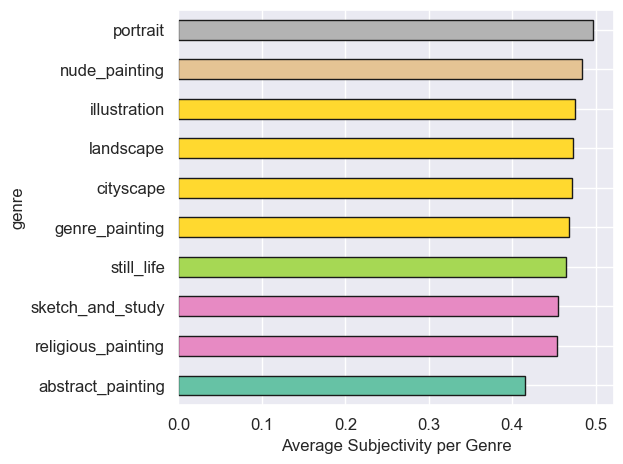

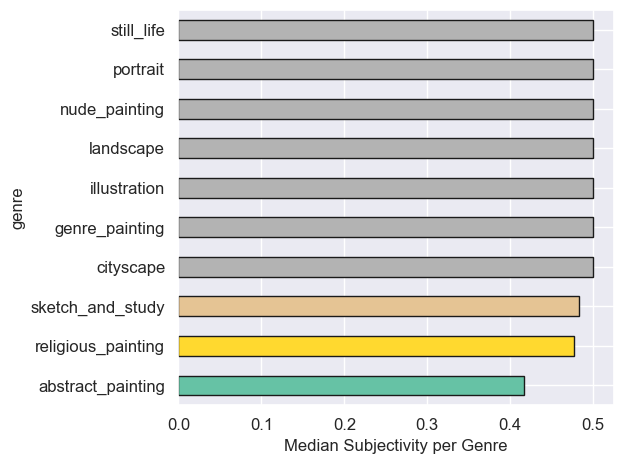

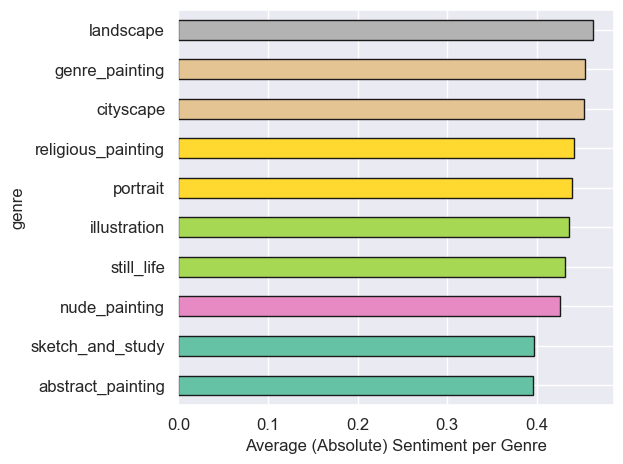

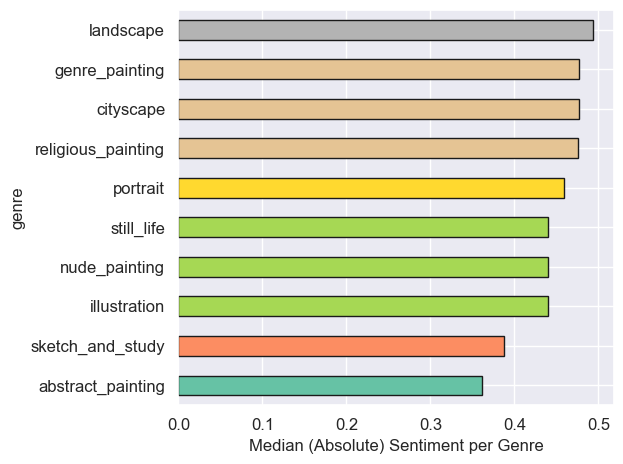

In [26]:
pallete = plt.cm.Set2

for metric in ['subjectivity_scores', 'sentiment_abs_scores']:
    for stat in ['average', 'median']:
        
        if stat == 'average':
            s = m.groupby('genre')[metric].mean().sort_values()
        else:
            s = m.groupby('genre')[metric].median().sort_values()
            
        fig = plt.figure()
        norm = plt.Normalize(s.min(), s.max())
        colors = plt.cm.Set2(norm(s.values))                
        ax = s.plot.barh(grid=True, color=colors, ec="k", fontsize=12)        

        name_of_metric = metric.split('_')[0].capitalize()
        
        if metric == 'sentiment_abs_scores':                        
            xlabel = '{} (Absolute) Sentiment per Genre'.format(stat.capitalize())
        else:            
            xlabel = '{} {} per Genre'.format(stat.capitalize(), name_of_metric)        
        
        ax.set_xlabel(xlabel)
        plt.tight_layout()      
        plt.show()  

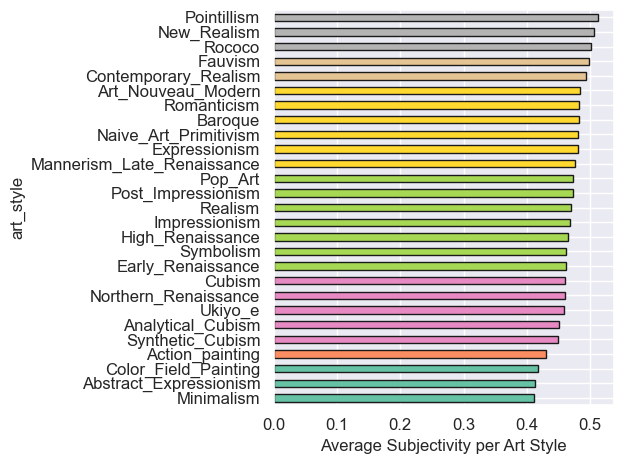

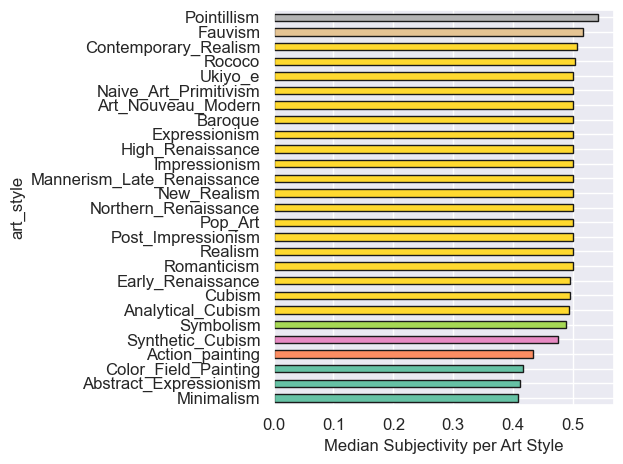

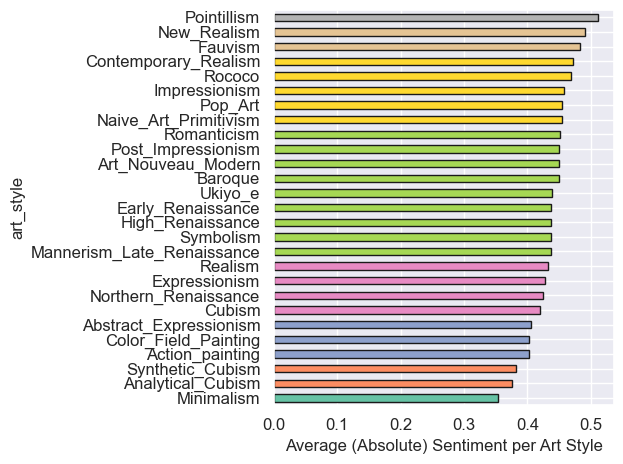

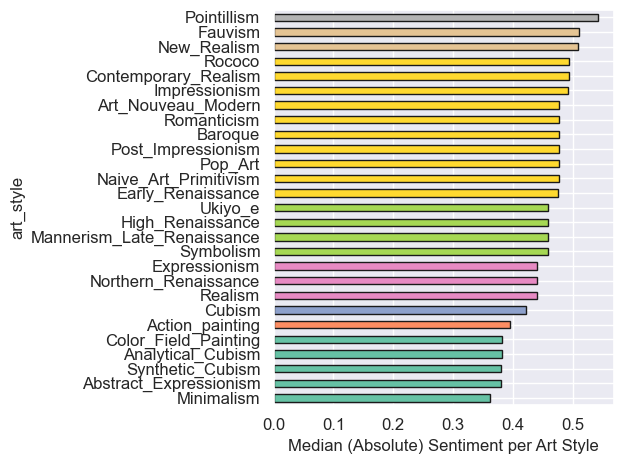

In [27]:
pallete = plt.cm.Set2

for metric in ['subjectivity_scores', 'sentiment_abs_scores']:
    for stat in ['average', 'median']:
        
        if stat == 'average':
            s = m.groupby('art_style')[metric].mean().sort_values()
        else:
            s = m.groupby('art_style')[metric].median().sort_values()
            
        fig = plt.figure()
        norm = plt.Normalize(s.min(), s.max())
        colors = plt.cm.Set2(norm(s.values))                
        ax = s.plot.barh(grid=True, color=colors, ec="k", fontsize=12)        

        name_of_metric = metric.split('_')[0].capitalize()
        
        if metric == 'sentiment_abs_scores':                        
            xlabel = '{} (Absolute) Sentiment per Art Style'.format(stat.capitalize())
        else:            
            xlabel = '{} {} per Art Style'.format(stat.capitalize(), name_of_metric)        
        
        ax.set_xlabel(xlabel)
        plt.tight_layout()      
        plt.show()  
        

In [ ]:
##
## Analyze the entrophy of emotions per art style and per art genre
##

In [11]:
# load histograms of emotion choices you created with extract_emotion_histogram_per_image.ipynb
image_hists_file = '../../data/image-emotion-histogram.csv'
image_hists = pd.read_csv(image_hists_file)

image_hists.emotion_histogram = image_hists.emotion_histogram.apply(literal_eval)
image_hists.emotion_histogram = image_hists.emotion_histogram.apply(lambda x: (np.array(x) / float(sum(x))).astype('float32'))
image_hists['entropy'] = image_hists.emotion_histogram.apply(entropy)

In [ ]:
# Load genre meta-annotations
g = pd.read_csv('../../data/wiki_art_genre_class.csv')
m = pd.merge(image_hists, g, on=['art_style', 'painting'])

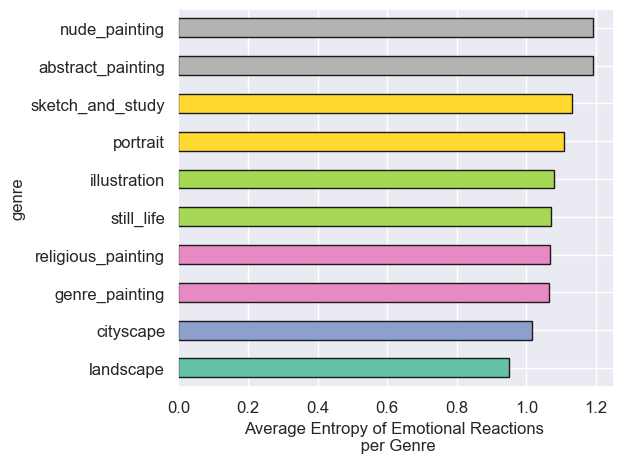

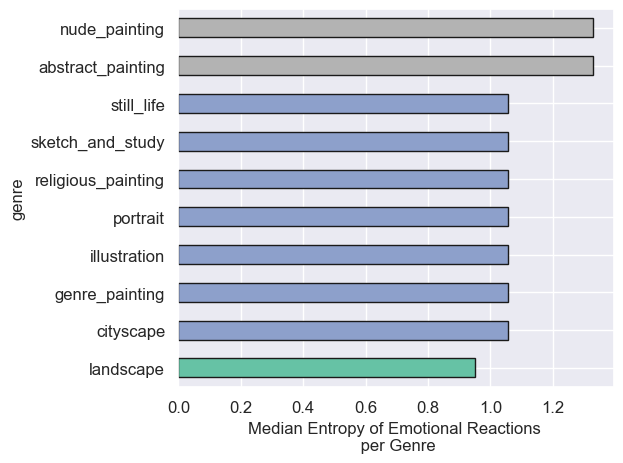

In [8]:
pallete = plt.cm.Set2

for stat in ['average', 'median']:
    if stat == 'average':
        s = m.groupby('genre')['entropy'].mean().sort_values()
    else:
        s = m.groupby('genre')['entropy'].median().sort_values()    

    plt.figure()
    norm = plt.Normalize(s.min(), s.max())
    colors = pallete(norm(s.values))
    ax = s.plot.barh(grid=True, color=colors, ec="k", fontsize=12)
    xlabel = '{} Entropy of Emotional Reactions \n per Genre'.format(stat.capitalize())
    ax.set_xlabel(xlabel)
    plt.tight_layout()    
    plt.show() 

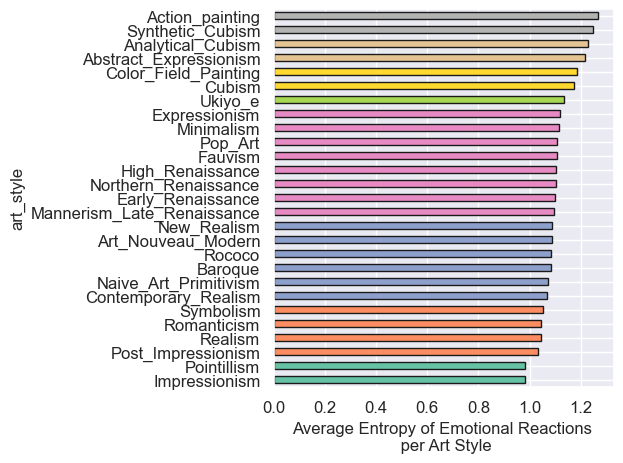

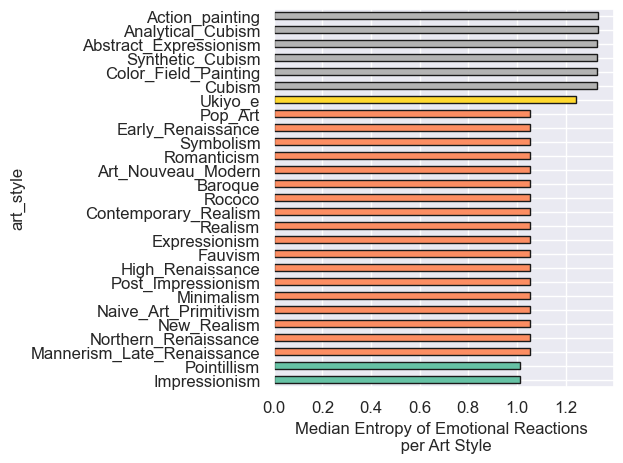

In [10]:
pallete = plt.cm.Set2

for stat in ['average', 'median']:
    if stat == 'average':
        s = m.groupby('art_style')['entropy'].mean().sort_values()
    else:
        s = m.groupby('art_style')['entropy'].median().sort_values()    

    plt.figure()
    norm = plt.Normalize(s.min(), s.max())
    colors = pallete(norm(s.values))
    ax = s.plot.barh(grid=True, color=colors, ec="k", fontsize=12)
    xlabel = '{} Entropy of Emotional Reactions \n per Art Style'.format(stat.capitalize())
    ax.set_xlabel(xlabel)
    plt.tight_layout()    
    plt.show() 